In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
#загрузим данные
games = pd.read_csv("games.csv")
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Шаг 3. Подготовьте данные
### Замените названия столбцов (приведите к нижнему регистру);

In [3]:
print(games.columns)
for col in games.columns:
    games.rename({col : col.lower()}, axis=1, inplace=True) 
games.head()

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
#для начала исследуем object
games.describe(include="object")

,name,platform,genre,user_score,rating
count,16713,16715,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


Столбцы name, platform не стоит заменять на числовые аналоги, а столбцы rating и genre, если бы было очень много данных, можно было бы заменить числами для экономии памяти. В столбце User_Score содержатся как числа, так и строки, хотя "user_score" — оценка пользователей (от 0 до 10), поэтому с этим стоит разобраться в дальнейшем

In [6]:
#заменим значения рейтинга на числа для дальнейшей замены пропусков
dict_with_r = dict(zip(games.rating.dropna().unique(), range(7)))
games.rating = games.rating.map(dict(zip(dict_with_r, range(7)))).astype("float16")

In [7]:
#изучим user_score со значением tbd
games_with_tbd = games[games['user_score'] == 'tbd']
games_with_tbd.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,0.0
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,3.0
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,2.0
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,0.0
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,0.0


В глаза бросается нулевое значение jp_score. Возможно, значение tbd ставится, когда нет продаж в каком-либо регионе

In [8]:
#сравним количество игр со значением tbd и со значением tbd и jp_sales = 0
print("tbd len: ", games_with_tbd.shape[0], "\ntbd + jap0 len: ", 
      games[(games['user_score'] == 'tbd') & (games['jp_sales'] == 0)].shape[0])

tbd len:  2424 
tbd + jap0 len:  2342


Кажется, что значение tbd зависит от продаж в jp. Пока заменим tbd на null и будем работать с этими данными

In [9]:
games_without_tbd = games.copy()
games_without_tbd.loc[games_without_tbd['user_score'] == 'tbd', 'user_score'] = np.nan 

In [10]:
#исследуем числовые типы
games_without_tbd.describe().T

,count,mean,std,min,25%,50%,75%,max
year_of_release,16446.0,2006.484616,5.877050,1980.0,2003.0,2007.00,2010.00,2016.00
na_sales,16715.0,0.263377,0.813604,0.0,0.0,0.08,0.24,41.36
eu_sales,16715.0,0.145060,0.503339,0.0,0.0,0.02,0.11,28.96
jp_sales,16715.0,0.077617,0.308853,0.0,0.0,0.00,0.04,10.22
other_sales,16715.0,0.047342,0.186731,0.0,0.0,0.01,0.03,10.57
critic_score,8137.0,68.967679,13.938165,13.0,60.0,71.00,79.00,98.00
rating,9946.0,1.187500,1.122070,0.0,0.0,1.00,2.00,6.00


Видим, что есть подозрительно высокие значения продаж для NA и EU регионов.

<AxesSubplot:>

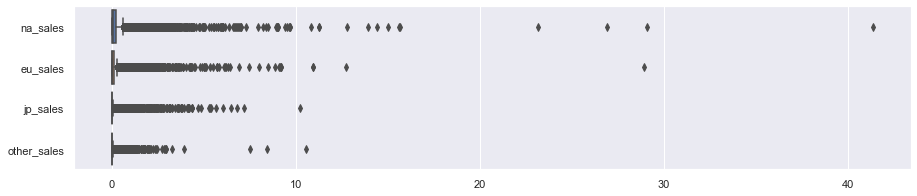

In [11]:
#Посмотрим, как они выглядят и являются ли выбросами
fig, ax = plt.subplots(figsize=(15, 3))
sns.boxplot(data=games_without_tbd[["na_sales", "eu_sales", "jp_sales", "other_sales"]], ax=ax, orient="h")

<AxesSubplot:>

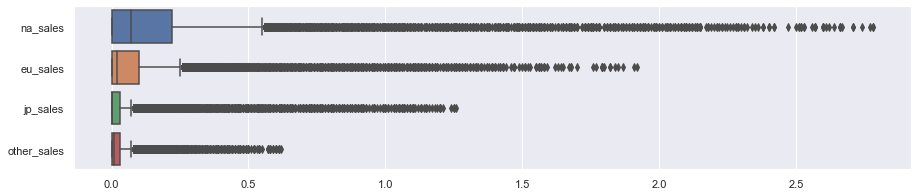

In [12]:
#Удалим явные выбросы в данных
games_without_tbd = games_without_tbd[(games_without_tbd["na_sales"]<games_without_tbd.na_sales.quantile(.99))\
                                      & (games_without_tbd["eu_sales"]<games_without_tbd.eu_sales.quantile(.99))\
                                      & (games_without_tbd["jp_sales"]<games_without_tbd.jp_sales.quantile(.99))
                                      & (games_without_tbd["other_sales"]<games_without_tbd.other_sales.quantile(.99))]
fig, ax = plt.subplots(figsize=(15, 3))
sns.boxplot(data=games_without_tbd[["na_sales", "eu_sales", "jp_sales", "other_sales"]], ax=ax, orient="h")

Как можно изменить типы  данных:

year_of_release (min 1980, max 2016, но данные могут дополняться), critic_score (min 0, max 100) -
    
    float64 -> int16 (max 65535), т.к. занимает много места и значения целые
    
    
na_sales, eu_sales, jp_sales, other_sales (min 0, max 41.36, но данные могут дополняться) -

    float64 -> float16, т.к. занимает много места
    
    
user_score (min 0, max 10) -

    object ->  float16

In [13]:
#изменим типы данных
def ch_type(col, data_type):
    games_without_tbd[col] = games_without_tbd[col].astype(data_type) 

In [14]:
ch_type("na_sales", "float16") 
ch_type("eu_sales", "float16")
ch_type("jp_sales", "float16")
ch_type("other_sales", "float16")
ch_type("user_score", "float16") 

In [15]:
games_without_tbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16319 entries, 166 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16317 non-null  object 
 1   platform         16319 non-null  object 
 2   year_of_release  16052 non-null  float64
 3   genre            16317 non-null  object 
 4   na_sales         16319 non-null  float16
 5   eu_sales         16319 non-null  float16
 6   jp_sales         16319 non-null  float16
 7   other_sales      16319 non-null  float16
 8   critic_score     7906 non-null   float64
 9   user_score       7353 non-null   float16
 10  rating           9706 non-null   float16
dtypes: float16(6), float64(2), object(3)
memory usage: 956.2+ KB


Для того, чтобы преобразовать другие столбцы, нужно разобраться с отсутствующими значениями в df. Еще раз посмотрим на общую информацию

In [16]:
#Всего 16715 значений, жанр отсутствует у 2 игр - 0.0001%, год у 267 игр - 0.016%, 
#данные пропуски могли произойти в следствие человекческого фактора. Т.к. %пропусков мал, их можно удалить
games_without_tbd = games_without_tbd[(~games_without_tbd["year_of_release"].isna()) & (~games_without_tbd["genre"].isna())]
ch_type("year_of_release", "int16")

In [17]:
games_without_tbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16050 entries, 166 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16050 non-null  object 
 1   platform         16050 non-null  object 
 2   year_of_release  16050 non-null  int16  
 3   genre            16050 non-null  object 
 4   na_sales         16050 non-null  float16
 5   eu_sales         16050 non-null  float16
 6   jp_sales         16050 non-null  float16
 7   other_sales      16050 non-null  float16
 8   critic_score     7754 non-null   float64
 9   user_score       7228 non-null   float16
 10  rating           9529 non-null   float16
dtypes: float16(6), float64(1), int16(1), object(3)
memory usage: 846.4+ KB


Пропусков в столбцах critic_score, user_score, rating слишком много, замена на какие-либо значения появляет на анализ данных. 
Т.к. для одной игры столбцы critic_score, user_score и rating примерно одинаковы, то можем восполнить недостающие значения.
Это видно на примере игры Need for Speed: Most Wanted (ниже), хотя есть исключения (для platform DS), поэтому используем median вместо mean

In [18]:
games_without_tbd[games_without_tbd["name"]=="Need for Speed: Most Wanted"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005,Racing,2.029297,1.790039,0.080017,0.469971,82.0,9.101562,2.0
523,Need for Speed: Most Wanted,PS3,2012,Racing,0.709961,1.459961,0.059998,0.580078,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012,Racing,0.620117,0.779785,0.010002,0.150024,83.0,8.500000,2.0
1591,Need for Speed: Most Wanted,X360,2005,Racing,1.000000,0.130005,0.020004,0.099976,83.0,8.500000,2.0
1998,Need for Speed: Most Wanted,XB,2005,Racing,0.529785,0.459961,0.000000,0.049988,83.0,8.796875,2.0
2048,Need for Speed: Most Wanted,PSV,2012,Racing,0.330078,0.449951,0.010002,0.219971,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005,Racing,0.429932,0.109985,0.000000,0.020004,80.0,9.101562,2.0
5972,Need for Speed: Most Wanted,PC,2005,Racing,0.020004,0.229980,0.000000,0.040009,82.0,8.500000,2.0
6273,Need for Speed: Most Wanted,WiiU,2013,Racing,0.130005,0.119995,0.000000,0.020004,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005,Racing,0.239990,0.010002,0.000000,0.020004,45.0,6.101562,0.0


In [19]:
#найдем медианы critic_score, user_score и rating для игр (для rating лучше всего находить самое частое значение, 
#но я не знаю, как это сделать)
games_with_scores = games_without_tbd.pivot_table(index="name", 
                                                  values=["user_score", "critic_score", "rating"], 
                                                  aggfunc="median").reset_index()
games_with_scores

,name,critic_score,rating,user_score
0,Tales of Xillia 2,71.0,2.0,7.898438
1,.hack//Infection Part 1,75.0,2.0,8.500000
2,.hack//Mutation Part 2,76.0,2.0,8.898438
3,.hack//Outbreak Part 3,70.0,2.0,8.703125
4,007 Racing,51.0,2.0,4.601562
...,...,...,...,...
5942,thinkSMART,NaN,0.0,NaN
5943,thinkSMART FAMILY!,NaN,0.0,NaN
5944,thinkSMART: Chess for Kids,NaN,0.0,NaN
5945,uDraw Studio,71.0,0.0,NaN


In [20]:
#посмотрим, какие получились значения rating 
games_with_scores.rating.value_counts()

0.0    2482
2.0    1802
1.0     848
3.0     710
1.5      23
2.5      14
6.0       5
4.0       2
Name: rating, dtype: int64

Значения 1.5 и 2.5 не подходят, т.к. это категориальные значения. Заменим их на 2, т.к. их гораздно больше чем 1 (в случае 1.5) или 3 (в случае 2.5)

In [21]:
#Замена значений
games_with_scores[(games_with_scores["rating"]==1.5) | (games_with_scores["rating"]==2.5)] = 2

In [22]:
#посмотрим, какие получились значения rating теперь
games_with_scores.rating.value_counts()

0.0    2482
2.0    1839
1.0     848
3.0     710
6.0       5
4.0       2
Name: rating, dtype: int64

In [23]:
#объеденим данные и посмотрим, что получилось на примере игры NFS
merge_games = games_without_tbd.merge(games_with_scores, on="name", how="outer")
merge_games[merge_games["name"]=="Need for Speed: Most Wanted"][["name", 
                                                                 "critic_score_x", "critic_score_y", 
                                                                 "user_score_x", "user_score_y", 
                                                                 "rating_x", "rating_y"]]

,name,critic_score_x,critic_score_y,user_score_x,user_score_y,rating_x,rating_y
25,Need for Speed: Most Wanted,82.0,82.0,9.101562,8.5,2.0,2.0
26,Need for Speed: Most Wanted,NaN,82.0,NaN,8.5,NaN,2.0
27,Need for Speed: Most Wanted,83.0,82.0,8.500000,8.5,2.0,2.0
28,Need for Speed: Most Wanted,83.0,82.0,8.500000,8.5,2.0,2.0
29,Need for Speed: Most Wanted,83.0,82.0,8.796875,8.5,2.0,2.0
30,Need for Speed: Most Wanted,NaN,82.0,NaN,8.5,NaN,2.0
31,Need for Speed: Most Wanted,80.0,82.0,9.101562,8.5,2.0,2.0
32,Need for Speed: Most Wanted,82.0,82.0,8.500000,8.5,2.0,2.0
33,Need for Speed: Most Wanted,NaN,82.0,NaN,8.5,NaN,2.0
34,Need for Speed: Most Wanted,45.0,82.0,6.101562,8.5,0.0,2.0


In [24]:
#Как видно на примере NFS, данные успешно восстановлены. Теперь заменим nan на полученные значения
merge_games["critic_score_x"] = merge_games["critic_score_x"].fillna(merge_games.critic_score_y)
merge_games["user_score_x"] = merge_games["user_score_x"].fillna(merge_games.user_score_y)
merge_games["rating_x"] = merge_games["rating_x"].fillna(merge_games.rating_y)
merge_games[merge_games["name"] == "Need for Speed: Most Wanted"][["name", 
                                                                   "critic_score_x", "critic_score_y", 
                                                                   "user_score_x","user_score_y"]]

,name,critic_score_x,critic_score_y,user_score_x,user_score_y
25,Need for Speed: Most Wanted,82.0,82.0,9.101562,8.5
26,Need for Speed: Most Wanted,82.0,82.0,8.500000,8.5
27,Need for Speed: Most Wanted,83.0,82.0,8.500000,8.5
28,Need for Speed: Most Wanted,83.0,82.0,8.500000,8.5
29,Need for Speed: Most Wanted,83.0,82.0,8.796875,8.5
30,Need for Speed: Most Wanted,82.0,82.0,8.500000,8.5
31,Need for Speed: Most Wanted,80.0,82.0,9.101562,8.5
32,Need for Speed: Most Wanted,82.0,82.0,8.500000,8.5
33,Need for Speed: Most Wanted,82.0,82.0,8.500000,8.5
34,Need for Speed: Most Wanted,45.0,82.0,6.101562,8.5


In [25]:
#удалим дополнительные столбцы и переименуем user_score_x и critic_score_x в таблице merge_games
merge_games = merge_games.drop(["user_score_y", "critic_score_y", "rating_y"], axis=1)
merge_games = merge_games.rename(columns={'user_score_x' : 'user_score', 
                                          'critic_score_x' : 'critic_score', 
                                          'rating_x' : 'rating'})
merge_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Mario Kart: Super Circuit,GBA,2001.0,Racing,2.619141,1.639648,0.990234,0.229980,93.0,8.296875,0.0
1,The Legend of Zelda: Phantom Hourglass,DS,2007.0,Action,1.849609,1.799805,0.950195,0.479980,90.0,8.000000,0.0
2,Super Smash Bros. for Wii U and 3DS,WiiU,2014.0,Fighting,2.599609,1.080078,0.810059,0.379883,NaN,NaN,NaN
3,StarCraft II: Wings of Liberty,PC,2010.0,Strategy,2.570312,1.679688,0.000000,0.580078,93.0,8.203125,2.0
4,God of War III,PS3,2010.0,Action,2.740234,1.330078,0.119995,0.609863,92.0,8.703125,1.0


In [26]:
#посмотрим на старые значения (с пропусками)
games_without_tbd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16050 entries, 166 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16050 non-null  object 
 1   platform         16050 non-null  object 
 2   year_of_release  16050 non-null  int16  
 3   genre            16050 non-null  object 
 4   na_sales         16050 non-null  float16
 5   eu_sales         16050 non-null  float16
 6   jp_sales         16050 non-null  float16
 7   other_sales      16050 non-null  float16
 8   critic_score     7754 non-null   float64
 9   user_score       7228 non-null   float16
 10  rating           9529 non-null   float16
dtypes: float16(6), float64(1), int16(1), object(3)
memory usage: 846.4+ KB


In [27]:
#посмотрим на количество пропусков теперь 
merge_games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16087 entries, 0 to 16086
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16087 non-null  object 
 1   platform         16050 non-null  object 
 2   year_of_release  16050 non-null  float64
 3   genre            16050 non-null  object 
 4   na_sales         16050 non-null  float16
 5   eu_sales         16050 non-null  float16
 6   jp_sales         16050 non-null  float16
 7   other_sales      16050 non-null  float16
 8   critic_score     8682 non-null   float64
 9   user_score       8274 non-null   float16
 10  rating           9955 non-null   float16
dtypes: float16(6), float64(2), object(3)
memory usage: 942.6+ KB


In [28]:
#как видим, мы восстановили ~1000 значений. Для удобства переименуем merge_games
#в data. Добавим новый столбец - сумма по всем регионам
data = merge_games.copy()
data["sum_regions"] = data.other_sales + data.na_sales + data.jp_sales + merge_games.eu_sales

In [29]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_regions
0,Mario Kart: Super Circuit,GBA,2001.0,Racing,2.619141,1.639648,0.990234,0.229980,93.0,8.296875,0.0,5.480469
1,The Legend of Zelda: Phantom Hourglass,DS,2007.0,Action,1.849609,1.799805,0.950195,0.479980,90.0,8.000000,0.0,5.082031
2,Super Smash Bros. for Wii U and 3DS,WiiU,2014.0,Fighting,2.599609,1.080078,0.810059,0.379883,NaN,NaN,NaN,4.871094
3,StarCraft II: Wings of Liberty,PC,2010.0,Strategy,2.570312,1.679688,0.000000,0.580078,93.0,8.203125,2.0,4.828125
4,God of War III,PS3,2010.0,Action,2.740234,1.330078,0.119995,0.609863,92.0,8.703125,1.0,4.796875


## Шаг 4. Проведите исследовательский анализ данных

### 1. Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

<AxesSubplot:xlabel='year_of_release', ylabel='count'>

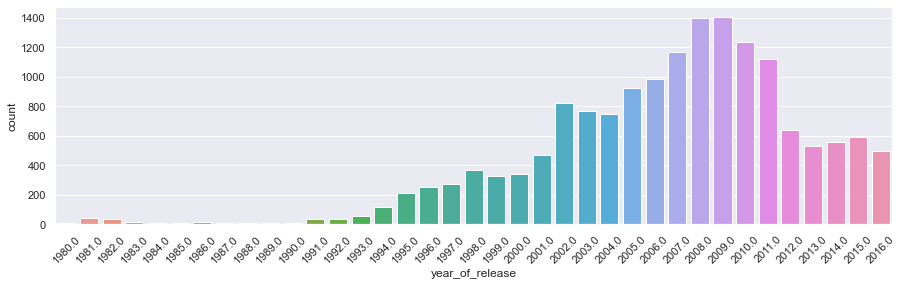

In [30]:
fig, ax = plt.subplots(figsize=(15, 4))
plt.xticks(rotation=45)
sns.countplot(data=data, x='year_of_release', ax=ax)

Как видно, можно отбросить данные до 1990 года. 

### 2. Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. Найдите популярные в прошлом платформы, у которых сейчас продажи на нуле. За какой характерный период появляются новые и исчезают старые платформы?

In [31]:
data = data[data["year_of_release"] > 1990]
#найдем самые прибыльные платформы
popular_platfs = data.pivot_table(index="platform", values="sum_regions", aggfunc="sum")\
.sort_values("sum_regions", ascending=False).reset_index().head(10)
list(popular_platfs.platform)

['PS2', 'PS3', 'X360', 'PS', 'DS', 'Wii', 'GBA', 'PSP', 'XB', 'PC']

<AxesSubplot:xlabel='year_of_release', ylabel='sum_regions'>

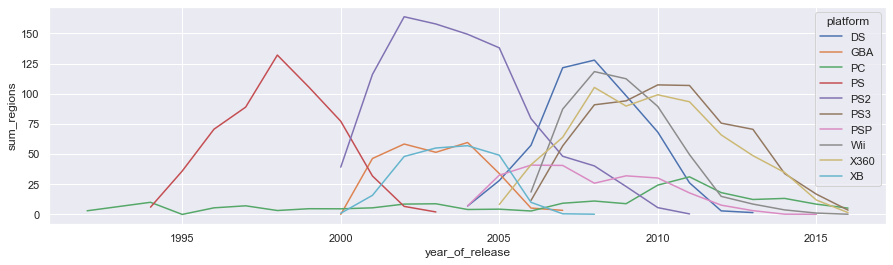

In [32]:
#сгрупируем данные по платформе и году и построим график
fig, ax = plt.subplots(figsize=(15, 4))
data_year_platf = data[data["platform"].isin(list(popular_platfs.platform))]\
                                    .pivot_table(index=["platform", "year_of_release"],
                                                 values="sum_regions", 
                                                 aggfunc="sum")
sns.lineplot(x="year_of_release", y="sum_regions", hue="platform", data=data_year_platf, estimator=None, ax=ax)


На графике видно, что каждая платформа, в среднем, "живет" 10 лет. Однако, к 2016 году продажи почти для всех платформ падают. Устаревшие платформы - PS, GBA, PS2, DS, PSP.

### 3-4. Определите, данные за какой период нужно взять, чтобы исключить значимое искажение распределения по платформам в 2016 году. Далее работайте только с данными, которые вы определили. Не учитывайте данные за предыдущие годы.
Т.к. каждый год ситуация меняется, возьмём данные за 2015-2016 год.

### 5-6. Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ. Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.

In [33]:
data_2015 = data[data["year_of_release"] >= 2015]
#найдем самые прибыльные платформы
popular_platfs2015 = data_2015.pivot_table(index="platform", 
                                           values="sum_regions", 
                                           aggfunc="sum").sort_values("sum_regions", ascending=False).reset_index().head(10)
list(popular_platfs2015.platform)

['PS4', 'XOne', '3DS', 'PS3', 'WiiU', 'PC', 'X360', 'PSV', 'Wii', 'PSP']

<AxesSubplot:xlabel='year_of_release', ylabel='sum_regions'>

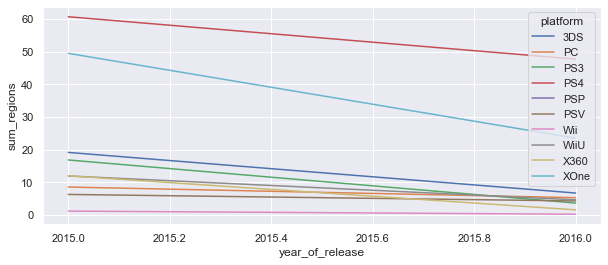

In [34]:
#сгрупируем данные по платформе и году и построим график для новых данных
fig, ax = plt.subplots(figsize=(10, 4))
data_year_platf2015 = data_2015[data_2015["platform"].isin(list(popular_platfs2015.platform))]\
                                    .pivot_table(index=["platform", "year_of_release"],
                                                 values="sum_regions", 
                                                 aggfunc="sum")
sns.lineplot(x="year_of_release", y="sum_regions", hue="platform", data=data_year_platf2015, estimator=None, ax=ax)

<AxesSubplot:xlabel='sum_regions', ylabel='platform'>

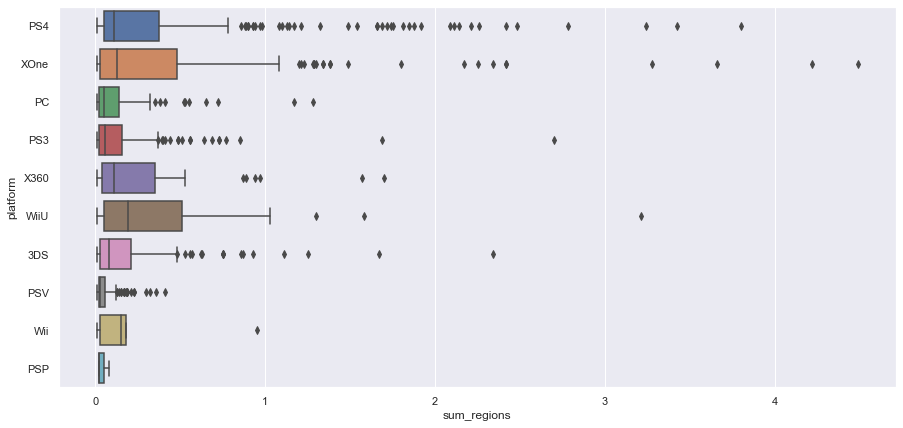

In [35]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(y="platform", x="sum_regions", data=data_2015, ax=ax, orient="h")

Значения примерно равны для WiiU, PS4, Xone, X360. Высокое значение 3 квартиля для Wii, однако, если посмотреть на график, то видно, что она уступает. Посмотрим, с чем это связано.

In [36]:
platform_sum_count = data_2015[~data_2015["sum_regions"].isna()].pivot_table(index="platform", 
                                                                                    values="sum_regions", 
                                                                                    aggfunc=["sum", "count"]).reset_index()
platform_sum_count.columns = ["platform", "sum", "count"]
platform_sum_count["sum_by_one_game"] = platform_sum_count["sum"]/platform_sum_count["count"]
platform_sum_count.sort_values("sum_by_one_game", ascending=False)

,platform,sum,count,sum_by_one_game
9,XOne,73.000000,164,0.445122
7,WiiU,16.515625,41,0.402820
3,PS4,108.437500,288,0.376519
8,X360,13.484375,48,0.280924
6,Wii,1.320312,5,0.264062
0,3DS,25.796875,127,0.203125
2,PS3,20.421875,111,0.183981
1,PC,13.765625,104,0.132362
5,PSV,10.500000,195,0.053846
4,PSP,0.119995,3,0.039998


Видно, что дело в количестве выпущенных игр. Если опираться на общие продажи, то наиболее прибыльные - PS4, XOne, 3DS. Если же опираться на продажи одной игры, то прибыльные - XOne, Wii, WiiU.

### 7. Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы и соотнесите их с продажами игр на других платформах.
Возьмём три потенциально прибыльные платформы - PS4, XOne, 3DS. Начнём с PS4 

Коэффициент корреляции для PS4 = 0.5745418050337442


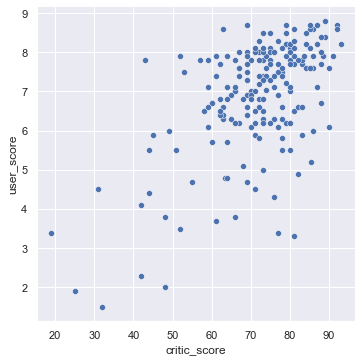

In [37]:
platf_PS4 = data_2015[(data_2015["platform"]=="PS4")]
print("Коэффициент корреляции для PS4 =", platf_PS4.critic_score.corr(platf_PS4.user_score))
sns.relplot(x="critic_score", y="user_score", data=platf_PS4)

Коэффициент корреляции для PS4 равен 0,55, т.е. "средняя корреляция". Видно, что основная масса оценок для пользователей - выше 6, для критиков - выше 60.

Коэффициент корреляции для XOne = 0.4886541799578501
Коэффициент корреляции для 3DS = 0.622122160914515


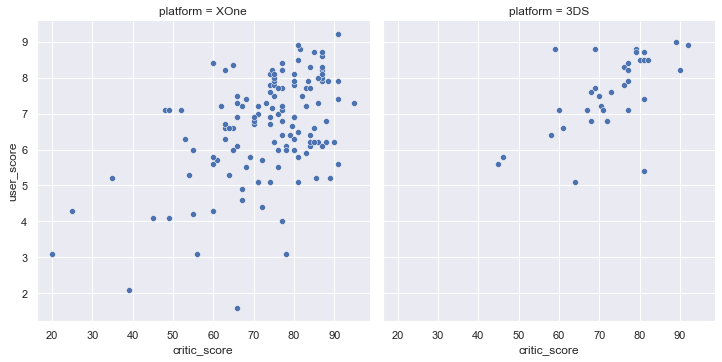

In [38]:
platf_XOne_3DS = data_2015[(data_2015["platform"]=="XOne") | 
                             (data_2015["platform"]=="3DS")]
platf_XOne = platf_XOne_3DS[(platf_XOne_3DS["platform"]=="XOne")]
platf_3DS = platf_XOne_3DS[(platf_XOne_3DS["platform"]=="3DS")]

print("Коэффициент корреляции для XOne =", platf_XOne.critic_score.corr(platf_XOne.user_score))
print("Коэффициент корреляции для 3DS =", platf_3DS.critic_score.corr(platf_3DS.user_score))
sns.relplot(x="critic_score", y="user_score", col="platform", data=platf_XOne_3DS)

Коэффициент корреляции для XOne равен 0.45, т.е. "слабая корреляция". Основная масса оценок для пользователей - выше 5, для критиков - выше 50, т.е. ниже, чем для PS4. 
Коэффициент корреляции для 3DS равен 0.6, т.е. "средняя корреляция". Стоит заметить, что данных гораздо меньше, чем у двух предыдущих платформ, а оценки больше 6 и 60.

### 8. Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Action'),
  Text(1, 0, 'Shooter'),
  Text(2, 0, 'Role-Playing'),
  Text(3, 0, 'Sports'),
  Text(4, 0, 'Platform'),
  Text(5, 0, 'Fighting'),
  Text(6, 0, 'Misc'),
  Text(7, 0, 'Racing'),
  Text(8, 0, 'Adventure'),
  Text(9, 0, 'Simulation'),
  Text(10, 0, 'Strategy'),
  Text(11, 0, 'Puzzle')])

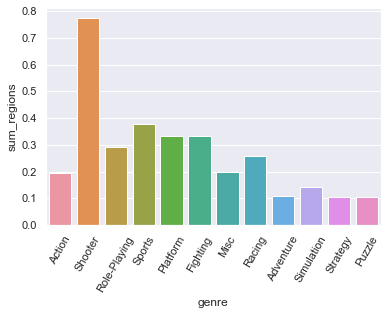

In [39]:
sns.barplot(x="genre", y="sum_regions", data=data_2015, ci=None)
plt.xticks(rotation=60)

In [40]:
genre_sum_count = data_2015[~data_2015["sum_regions"].isna()].pivot_table(index="genre", 
                                                                                    values="sum_regions", 
                                                                                    aggfunc=["sum", "count"]).reset_index()
genre_sum_count.columns = ["genre", "sum", "count"]
genre_sum_count["sum_by_one_game"] = genre_sum_count["sum"]/genre_sum_count["count"]
genre_sum_count.sort_values("sum_by_one_game", ascending=False)

,genre,sum,count,sum_by_one_game
8,Shooter,57.343750,74,0.774916
10,Sports,38.375000,102,0.376225
2,Fighting,12.367188,37,0.334248
4,Platform,9.281250,28,0.331473
7,Role-Playing,37.531250,129,0.290940
6,Racing,10.859375,42,0.258557
3,Misc,14.171875,71,0.199604
0,Action,83.250000,425,0.195882
9,Simulation,4.500000,32,0.140625
1,Adventure,11.976562,110,0.108878


Выделяется жанр shooter, который принес примерно в два раза больше прибыли для одной игры, чем следующий после него жанр - sports. Также низкими продажами выделяются жанры adventure, puzzle и strategy. 

## Шаг 5. Составьте портрет пользователя каждого региона. Определите для пользователя каждого региона (NA, EU, JP):
### 1. Самые популярные платформы (топ-5). Опишите различия в долях продаж.

In [41]:
#сгруппируем данные по платформам и годам
data_for_regs = data_2015.pivot_table(index=["platform", "year_of_release"], 
                                           values=["na_sales", "eu_sales", "jp_sales", "sum_regions"], 
                                           aggfunc="sum").reset_index()

data_for_regs.groupby("platform").sum().reset_index()\
              .sort_values("sum_regions", ascending=False)\
              [["platform", "na_sales", "eu_sales", "jp_sales"]]

,platform,na_sales,eu_sales,jp_sales
3,PS4,38.062500,44.218750,10.031250
9,XOne,44.375000,21.828125,0.170044
0,3DS,6.550781,4.710938,13.484375
2,PS3,5.656250,7.296875,4.968750
7,WiiU,7.320312,5.312500,2.660156
1,PC,3.718750,9.101562,0.000000
8,X360,8.046875,4.210938,0.000000
5,PSV,0.540039,1.080078,8.414062
6,Wii,0.489990,0.729980,0.000000
4,PSP,0.000000,0.000000,0.119995


В таблице видно, что NA и EU регионы суммарно по всем платформам примерно равны (где-то больше продаж у одного, где-то у другого), а вот JP регион сильно отстает по продажам. Лидируют платформы PS4 и XOne.

In [42]:
#найдём самые популярные платформы для NA региона
data_for_regs.groupby("platform")\
             .sum()\
             .reset_index()\
             .sort_values("na_sales", ascending=False)[["platform", "na_sales"]]\
             .head(5)

,platform,na_sales
9,XOne,44.375000
3,PS4,38.062500
8,X360,8.046875
7,WiiU,7.320312
0,3DS,6.550781


Платформы PS4 и XOne сильно лидируют в данном регионе, что иллюстрирует график ниже.  

<AxesSubplot:xlabel='year_of_release', ylabel='na_sales'>

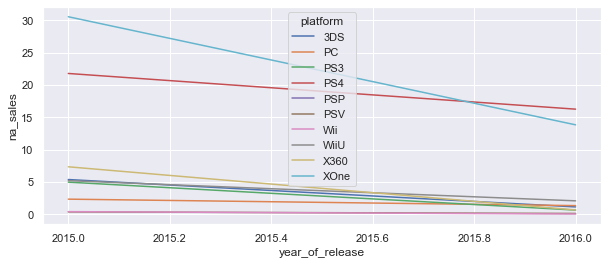

In [43]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(x="year_of_release", y="na_sales", hue="platform", data=data_for_regs, estimator=None, ax=ax)

In [44]:
#найдём самые популярные платформы для EU региона
data_for_regs.groupby("platform")\
             .sum()\
             .reset_index()\
             .sort_values("eu_sales", ascending=False)[["platform", "eu_sales"]]\
             .head(5)

,platform,eu_sales
3,PS4,44.218750
9,XOne,21.828125
1,PC,9.101562
2,PS3,7.296875
7,WiiU,5.312500


В данном регионе сильно лидирует платформа PS4, что иллюстрирует график ниже.

<AxesSubplot:xlabel='year_of_release', ylabel='eu_sales'>

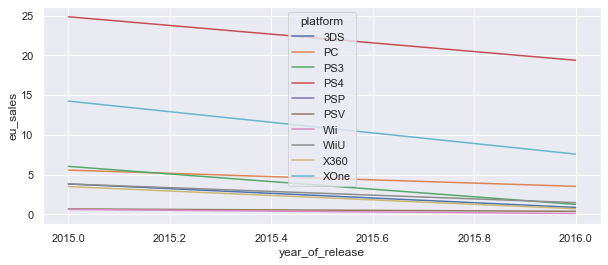

In [45]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(x="year_of_release", y="eu_sales", hue="platform", data=data_for_regs, estimator=None, ax=ax)

In [46]:
#найдём самые популярные платформы для JP региона
data_for_regs.groupby("platform")\
             .sum()\
             .reset_index()\
             .sort_values("jp_sales", ascending=False)[["platform", "jp_sales"]]\
             .head(5)

,platform,jp_sales
0,3DS,13.484375
3,PS4,10.031250
5,PSV,8.414062
2,PS3,4.968750
7,WiiU,2.660156


В данном регионе продажи в 3 раза выше у платформы 3DS, что иллюстрирует график ниже. Однако, продажи для данной платформы с каждым годом ниже, в перспективе PS4 кажется выгоднее.

<AxesSubplot:xlabel='year_of_release', ylabel='jp_sales'>

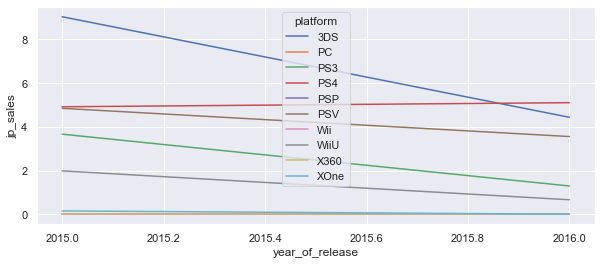

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(x="year_of_release", y="jp_sales", hue="platform", data=data_for_regs, estimator=None, ax=ax)

### 2. Самые популярные жанры (топ-5). Поясните разницу.

In [48]:
#сгруппируем данные по жанрам и годам
genre_data_for_regs = data_2015.pivot_table(index=["genre", "year_of_release"], 
                                                 values=["na_sales", "eu_sales", "jp_sales", "sum_regions"], 
                                                 aggfunc="sum").reset_index()

genre_data_for_regs.groupby("genre")\
                   .sum().reset_index()\
                   .sort_values("sum_regions", ascending=False)\
                   [["genre", "na_sales", "eu_sales", "jp_sales"]]

,genre,na_sales,eu_sales,jp_sales
0,Action,29.000000,29.218750,16.390625
8,Shooter,28.468750,21.000000,1.190430
10,Sports,20.718750,11.125000,1.480469
7,Role-Playing,13.296875,10.359375,10.687500
3,Misc,5.582031,4.257812,3.191406
2,Fighting,5.539062,3.718750,1.540039
1,Adventure,3.839844,4.671875,2.218750
6,Racing,2.820312,6.519531,0.290039
4,Platform,3.781250,3.199219,1.419922
9,Simulation,0.850098,2.720703,0.529785


В таблице видно, что для всех регионов сильно лидируют жанры Action и Shoter, как было отмечено выше, для NA и EU продажи по жанрам примерно одинаковы, сильно выделяется регион JP.

In [49]:
#найдём самые популярные жанры для NA региона
genre_data_for_regs.groupby("genre")\
                   .sum()\
                   .reset_index()\
                   .sort_values("na_sales", ascending=False)[["genre", "na_sales"]]\
                   .head(5)

,genre,na_sales
0,Action,29.000000
8,Shooter,28.468750
10,Sports,20.718750
7,Role-Playing,13.296875
3,Misc,5.582031


Для региона NA более прибыльные жанры - Shooter и Action, причем Shooter немного прибыльнее. 

In [50]:
#найдём самые популярные жанры для EU региона
genre_data_for_regs.groupby("genre")\
                   .sum()\
                   .reset_index()\
                   .sort_values("eu_sales", ascending=False)[["genre", "eu_sales"]]\
                   .head(5)

,genre,eu_sales
0,Action,29.218750
8,Shooter,21.000000
10,Sports,11.125000
7,Role-Playing,10.359375
6,Racing,6.519531


Для региона EU более прибыльные жанры - Shooter и Action, причем Action прибыльнее, и разница между Action и Shooter больше, чем для NA региона.

In [51]:
#найдём самые популярные жанры для JP региона
genre_data_for_regs.groupby("genre")\
                   .sum()\
                   .reset_index()\
                   .sort_values("jp_sales", ascending=False)[["genre", "jp_sales"]]\
                   .head(8)

,genre,jp_sales
0,Action,16.390625
7,Role-Playing,10.687500
3,Misc,3.191406
1,Adventure,2.218750
2,Fighting,1.540039


Кардинально отличается ситуация в JP регионе. Shooter занимает 5е место, а лидируют Role-Playing и Action. 

### 3. Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [52]:
#выведем значения, на которые мы заменили рейтинги
dict_with_r

{'E': 0, 'M': 1, 'T': 2, 'E10+': 3, 'K-A': 4, 'AO': 5, 'EC': 6}

In [53]:
data_2015.rating = data_2015.rating.map({0:"E", 1:"M", 2:"T", 3:"E10+", 4:"K-A", 5:"AO", 6:"EC"})

<BarContainer object of 4 artists>

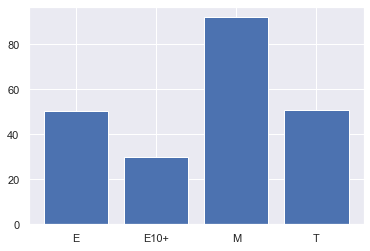

In [54]:
#сначала посмотрим, как распределились рейтинги для всех регионов
grouped_rating = data_2015.groupby("rating").sum().reset_index()
plt.bar(grouped_rating.rating, grouped_rating.sum_regions)

<BarContainer object of 4 artists>

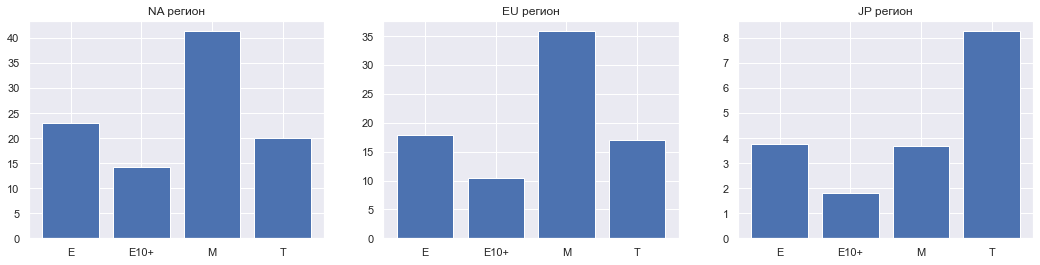

In [55]:
#теперь посмотрим, как распределились рейтинги для каждого региона
fig = plt.figure(figsize=(18, 4))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)
ax1.set_title('NA регион')
ax2.set_title('EU регион')
ax3.set_title('JP регион')
ax1.bar(grouped_rating.rating, grouped_rating.na_sales)
ax2.bar(grouped_rating.rating, grouped_rating.eu_sales)
ax3.bar(grouped_rating.rating, grouped_rating.jp_sales)

Видно, что для NA и EU регионов рейтинги примерно одинаковы, по продажам лидирует рейтинг M. В регионе JP больше всего продаж игр с рейтингом T. 

## Шаг 6. Проведите исследование статистических показателей
### Как изменяется пользовательский рейтинг и рейтинг критиков в различных жанрах? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения

In [56]:
scores_genre = data_2015.pivot_table(index="genre", values=["user_score", "critic_score"]).reset_index()
scores_genre

,genre,critic_score,user_score
0,Action,72.092233,6.792969
1,Adventure,74.291667,7.488281
2,Fighting,71.620690,7.027344
3,Misc,74.517241,6.894531
4,Platform,75.428571,6.101562
5,Puzzle,76.000000,7.765625
6,Racing,71.937500,6.558594
7,Role-Playing,76.176471,7.714844
8,Shooter,75.283333,6.386719
9,Simulation,68.400000,6.593750


In [57]:
critic_mean = data_2015.critic_score.mean()
critic_var = np.var(data_2015.critic_score)
critic_sq = np.sqrt(critic_var)
print("Средняя оценка критиков: {0}, дисперсия: {1}, ст. отклонение: {2}".format(critic_mean, critic_var, critic_sq))

Средняя оценка критиков: 72.46083333333333, дисперсия: 168.91054930555535, ст. отклонение: 12.996559133307375


<AxesSubplot:title={'center':'Все оценки критиков по данным после 2015 г.'}, xlabel='critic_score', ylabel='Count'>

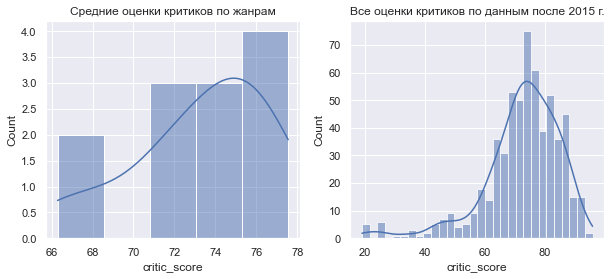

In [58]:
fig = plt.figure(figsize=(10, 4))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set_title('Средние оценки критиков по жанрам')
ax2.set_title('Все оценки критиков по данным после 2015 г.')
sns.histplot(data=scores_genre, x="critic_score", kde=True, ax=ax1)
sns.histplot(data=data_2015, x="critic_score", kde=True, bins=30, ax=ax2)

In [59]:
user_mean = scores_genre.user_score.mean()
user_var = np.var(scores_genre.user_score)
user_sq = np.sqrt(user_var)
print("Средняя оценка пользователей: {0}, дисперсия: {1}, ст. отклонение: {2}".format(user_mean, user_var, user_sq))

Средняя оценка пользователей: 6.8125, дисперсия: 0.50634765625, ст. отклонение: 0.71142578125


<AxesSubplot:title={'center':'Все оценки пользователей по данным после 2015 г.'}, xlabel='user_score', ylabel='Count'>

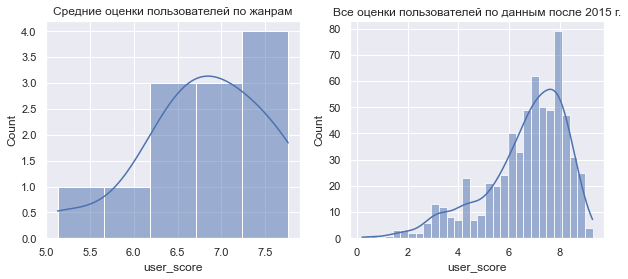

In [60]:
fig = plt.figure(figsize=(10, 4))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set_title('Средние оценки пользователей по жанрам')
ax2.set_title('Все оценки пользователей по данным после 2015 г.')
sns.histplot(data=scores_genre, x="user_score", kde=True, ax=ax1)
sns.histplot(data=data_2015, x="user_score", kde=True, bins=30, ax=ax2)

## Шаг 7. Проверьте гипотезы
### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
Альтернативная гипотеза - средние пользовательские рейтинги платформ Xbox One и PC не одинаковые

In [61]:
results_platf = st.ttest_ind(data_2015[data_2015["platform"]=="XOne"].user_score, 
                       data_2015[data_2015["platform"]=="PC"].user_score, 
                       equal_var = False, nan_policy="omit")
print('p-значение: ', results_platf.pvalue)
alpha = 0.05
if (results_platf.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.12428094683658635
Не получилось отвергнуть нулевую гипотезу


<AxesSubplot:title={'center':'Оценки пользователей для PC'}, xlabel='user_score', ylabel='Count'>

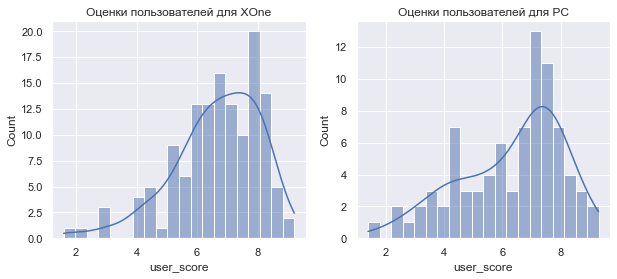

In [62]:
fig = plt.figure(figsize=(10, 4))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set_title('Оценки пользователей для XOne')
ax2.set_title('Оценки пользователей для PC')
sns.histplot(data=data_2015[data_2015["platform"]=="XOne"], x="user_score", kde=True, ax=ax1, bins=20)
sns.histplot(data=data_2015[data_2015["platform"]=="PC"], x="user_score", kde=True, ax=ax2, bins=20)

Т.к. p-value получилось меньше порогового значения, отвергаем нулевую гипотезу, значит, средние пользовательские рейтинги разные для двух платформ. 

### Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.
Т.к. мы используем t-test (ttest_ind) из пакета stats, то нулевая гипотеза - пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») равны, альтернативная - не равны.  
* Документация ttest_ind: "This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default."

In [63]:
results_gen = st.ttest_ind(data_2015[data_2015["genre"]=="Action"].user_score, 
                       data_2015[data_2015["genre"]=="Sports"].user_score, 
                       equal_var = False, nan_policy="omit")
print('p-значение: ', results_gen.pvalue)
alpha = 0.05
if (results_platf.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.7039923856765368e-11
Не получилось отвергнуть нулевую гипотезу


<AxesSubplot:title={'center':'Оценки пользователей для Sports'}, xlabel='user_score', ylabel='Count'>

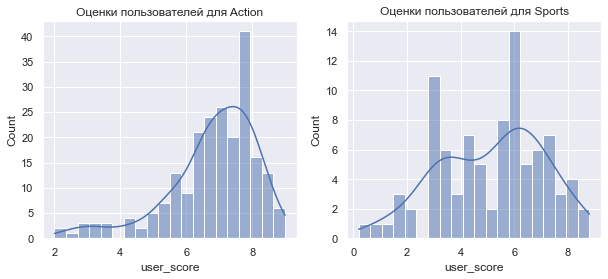

In [64]:
fig = plt.figure(figsize=(10, 4))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set_title('Оценки пользователей для Action')
ax2.set_title('Оценки пользователей для Sports')
sns.histplot(data=data_2015[data_2015["genre"]=="Action"], x="user_score", kde=True, ax=ax1, bins=20)
sns.histplot(data=data_2015[data_2015["genre"]=="Sports"], x="user_score", kde=True, ax=ax2, bins=20)

Т.к. p-value получилось меньше порогового значения, отвергаем нулевую гипотезу, значит, средние пользовательские рейтинги разные для двух жанров. 

## Шаг 8. Напишите общий вывод

1. Данные содержали 11 столбцов и 16715 строк, при этом только 8137 строк были без нулевых значений. Столбец "user_score" содержал значения tbd (2424 строки), что в дальнейшем приравнивалось к нулевому значению.
Максимальные продажи для NA, EU, JP регионов - 41.36 млн, 28.96 млн, 10.22 млн, соответственно.

2. Популярность консолей выросла после 1990 года, если судить по данным, но, возможно, данных до 1990 года просто недостаточно. Максимальные продажи наблюдались в 2008-2009 годах, после 2011 года произошёл резкий спад продаж. 
Всего рассматривалось 31 платформа, самая ранняя - 2600 (данные начинаются с 1985 г.), самая долгоживущая - PC (31 год)
Топ-10 платформ по суммарным продажам: PS2, PS3, X360, PS, DS, Wii, GBA, PSP, XB, PC.
Средняя продолжительность жизни платформы из этих топ-10 - 10 лет. Средняя продолжительность жизни по всем данным без учёта выбросов (например, PC) - 6-8 лет. Устаревших платформ очень много, например: 2600, 3DO, PS, GB, DС, SAT и т.д. 
Самые популярные платформы: если опираться на общие продажи, то наиболее прибыльные - PS4, XOne, 3DS. Если же опираться на продажи одной игры, то прибыльные - XOne, Wii, WiiU, однако самой перспективной является PS4.

3. Также была рассмотрена корреляция между продажами и отзывами критиков\пользователей на примере 3 платформ - PS4, XOne, 3DS. Коэффициенты корреляции оказались довольно низкими, т.е. какой-то явной связи не прослеживается, однако на графиках видно, что игры с высокими продажами практически не имеют плохих отзывов от критиков (~все отзывы>70).

4. (суммарно по всем регионам) 
Самые прибыльные жанры: Action, Shooter, Sports и Role-Playing.  
Самые неприбыльные: Simulation, Strategy, Puzzle  
* Для региона NA более прибыльные жанры - Shooter и Action.
* Для региона EU более прибыльные жанры - Shooter и Action, причем Action прибыльнее, и разница между Action и Shooter больше, чем для NA региона.
* Кардинально отличается ситуация в JP регионе. Лидируют Role-Playing и Action.

5. Для NA и EU регионов рейтинги примерно одинаковы, по продажам лидирует рейтинг M. В регионе JP больше всего продаж игр с рейтингом T.

6. Были проверены 2 гипотезы. С помощью теста Левена оценены дисперсии выборок для обеих гипотез, после чего проведены t-тесты, alpha = 0.05.
* 1. Нулевая гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Альтернативная гипотеза - средние пользовательские рейтинги платформ Xbox One и PC не одинаковые
Для дисперсий p-value = 0.0452, т.е. дисперсии разные, для t-теста equal_var = False. p-value для t-теста равен 0.1243. Т.к. p-value получилось меньше порогового значения, отвергаем нулевую гипотезу, значит, средние пользовательские рейтинги разные для двух платформ.
* 2. Нулевая гипотеза - пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») равны. Альтернативная гипотеза - пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») не равны
Для дисперсий p-value = 0.0025, т.е. дисперсии разные, для t-теста equal_var = False. p-value для t-теста =~0. Т.к. p-value получилось меньше порогового значения, отвергаем нулевую гипотезу, значит, средние пользовательские рейтинги разные для двух жанров.